In [137]:
import numpy as np
from scipy import fft as fft
from scipy.sparse.linalg import LinearOperator
from matplotlib import pyplot as plt
  
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

class Operator(LinearOperator):
    def __init__(self, N, L=1):
        self.L = L
        self.N = N
        self.shape = (self.N,self.N)
        self.x = np.linspace(0, self.L, num=self.N, endpoint=False)

    
class FourierMultiplier(Operator):

    def __init__(self, N, L=1, transform='dct'):
        super().__init__(N=N, L=L)
        self.dtype = None
        self.freqs = fft.fftfreq(self.N, d=self.L/self.N)
        self.multiplier = None ## Need to implement this on particular case
        self.transform = transform
        if self.transform == 'dct':
            self.fwd = fft.dct
            self.inv = fft.idct
            self.func = np.cos
        elif self.transform == 'dst':
            self.fwd = fft.dst
            self.inv = fft.idst
            self.func = np.sin
        elif self.transform == 'fft':
            self.fwd = np.fft.fft
            self.inv = np.fft.ifft
            self.func = lambda x: np.exp(2j*x)
            
    
    def eigenfunction(self, i):
        return lambda x: self.func(np.pi*self.freqs[i]*x)
        
    def to_freq_domain(self, u):
        return self.fwd(u)/np.sqrt(self.N)
    
    def to_time_domain(self, u):
        return self.inv(u) * np.sqrt(self.N)
    
    def coeff2u(self, coeff):
        res = sum(coeff[i]*self.eigenfunction(i)(self.x) for i in np.where(np.abs(coeff) > 1e-5)[0])
        return res    
    
    def _matvec(self, v):
        return self(np.squeeze(v))
    
    def __call__(self, v):
        v_hat = self.to_freq_domain(v)
        Av_hat = v_hat * self.multiplier
        Av = self.to_time_domain(Av_hat) 
        return Av + np.mean(v)

    def random(self, return_coeffs=False, beta=1.137):
        if self.transform == 'fft':
            coeffs = np.random.randn(self.N, 2).view(np.complex128) 
            coeffs = np.squeeze(coeffs)
        else:
            coeffs = np.random.randn(self.freqs.size)
        coeffs /= (np.arange(coeffs.size)+1)**beta
        coeffs[0] = 0
        
        u0 = self.coeff2u(coeffs) 
        return u0, coeffs if return_coeffs else u0 

    
    
class Heat(FourierMultiplier):
    def __init__(self, time, alpha=1, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.time = time
        self.multiplier = np.exp(-self.alpha * np.pi**2 * self.time * self.freqs**2)
          

class Laplacian(FourierMultiplier):
    def __init__(self, alpha, **kwargs):
        super().__init__(**kwargs)
        self.multiplier = np.power(np.pi**2 * self.freqs**2, alpha)
        self.multiplier[0] = 1
      
    def __call__(self, v):
        return super().__call__(v)
        
    
class LinearFunctional(FourierMultiplier):
    def __init__(self, multiplier, **kwargs):
        super().__init__(**kwargs)
        assert multiplier.shape == (self.N,)
        self.multiplier = multiplier
    
    def __call__(self, v):
        return np.dot(self.to_freq_domain(v), self.multiplier)

class PointObservation(FourierMultiplier):
    def __init__(self, pt, **kwargs):
        super().__init__(**kwargs)
        self.pt = pt
        #delta = np.zeros(self.N)
        #ind = np.searchsorted(self.x, pt)
        #delta[ind] = 1
        #self.delta = delta
        #self.multiplier1 = self.to_freq_domain(delta)
        self.multiplier = np.array([self.eigenfunction(i)(-pt) for i in range(self.N)]) / np.sqrt(self.N)
        
    
    def __call__(self, v):
        #return np.dot(v,self.delta)
        return np.vdot(self.to_freq_domain(v), self.multiplier)

    
class Observation(FourierMultiplier):
    def __init__(self, meas=[], functionals=[], **kwargs):
        super().__init__(**kwargs)
        self.meas = meas
        self.functionals = functionals
        self.operators = [PointObservation(m, **kwargs) for m in meas] + [LinearFunctional(func, **kwargs) for func in functionals]
        
    def __call__(self, v):
        return np.array([op(v) for op in self.operators])
       

<ipython-input-137-4e5e802e7f1a>:86: RuntimeWarning: divide by zero encountered in power
  self.multiplier = np.power(np.pi**2 * self.freqs**2, alpha)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


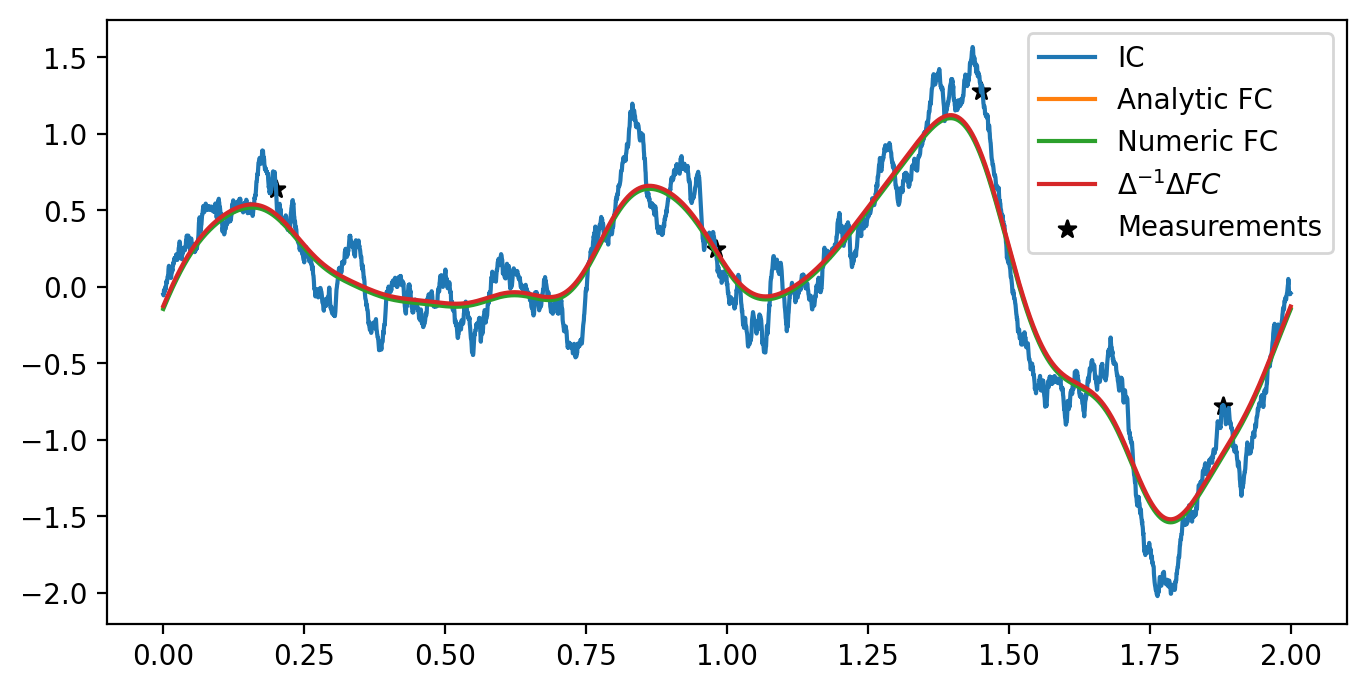

In [150]:
N = 5000
L = 2
time = 2e-3
alpha = 2.6
transform = 'fft'
#kwargs = {'L': 2,
#          'N': 5000,
#          'transform': 'fft'}

fwd = Heat(N=N, L=L, alpha=alpha, time=time, transform=transform)
lap = Laplacian(alpha=alpha, N=N, L=L, transform=transform)
invlap = Laplacian(alpha=-alpha, N=N, L=L, transform=transform)
obs = Observation(meas=[0.2, 0.98, 1.45, 1.88], L=L, N=N, transform=transform)



# IC
u0, coeffs0 = fwd.random(return_coeffs=True, beta=1.2)

# Analytic
coeffsT = coeffs0 * fwd.multiplier
uT = fwd.coeff2u(coeffsT)

# Numeric solution
uT_num = fwd(u0)
        
plt.plot(fwd.x, u0.real, label='IC')
plt.plot(fwd.x, uT.real, label='Analytic FC')
plt.plot(fwd.x, uT_num.real-0.01, label='Numeric FC')
#plt.plot(lap.x, lap(invlap(uT))+0.025, label=r'$\Delta\Delta^{-1} FC$')
plt.plot(lap.x, invlap(lap(uT))+0.01, label=r'$\Delta^{-1}\Delta FC$')
plt.scatter(obs.meas, obs(u0).real, label='Measurements', marker='*', s =40, color='k', zorder=1)

plt.legend()
#plt.close()

In [73]:
ind = 500
x = obs1.x[ind] # 0.2
delta = np.zeros(obs1.N)
delta[ind] = 
f_delta = obs1.to_freq_domain(delta)


obs3.pt, obs3(coeffs0) * N

(1.52, (-0.16510030891195002+0.286450204361136j))

In [111]:
v = np.random.randn(N)

(np.linalg.norm(v) / np.linalg.norm(obs1.to_freq_domain(v)))


1.0